# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import setup_multi_gpus, create_corr_matrix, reduce_memory, resample_df, df_to_lstm_format

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline
sns.set()

Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Setup multi GPU usage
num_gpu = setup_multi_gpus()

Amount of GPUs available: 4


# Load data

In [3]:
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed/all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
df = resample_df(df, 'D', combine_all_dwellings=True)

#df['year'] = df.index.year
#df['month'] = df.index.month
#df['day'] = df.index.day
#df['hour'] = df.index.hour #create column containing the hour
#df['dayofweek'] = df.index.dayofweek
#df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)


In [4]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling
datetime,,,,,,,,,,,,,,,,,,,
2017-02-22,185.730438,0.0,243.831944,444.333333,8.236250,12.023750,7.388889,1005.554169,30.708333,1.112500,0.000000,9.236111,8.973611,8.283333,93.319444,9911.805583,54.069444,0.256246,All dwellings
2017-02-23,173.374907,0.0,239.148194,265.916667,11.608438,17.165569,7.612500,995.103327,24.312500,0.461319,0.149737,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,0.485713,All dwellings
2017-02-24,246.992340,0.0,278.093543,45.766667,5.032826,7.413604,4.665972,1011.765422,107.562499,0.054306,2.962413,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,0.276830,All dwellings
2017-02-25,150.144606,0.0,202.265418,14.750000,6.502271,9.496715,6.166667,1016.465144,49.312501,0.002083,0.361316,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.017166,All dwellings
2017-02-26,679.171475,0.0,208.350207,82.633334,7.540049,11.129507,7.694444,1008.878202,24.770834,0.098611,0.039483,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,0.503001,All dwellings


Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

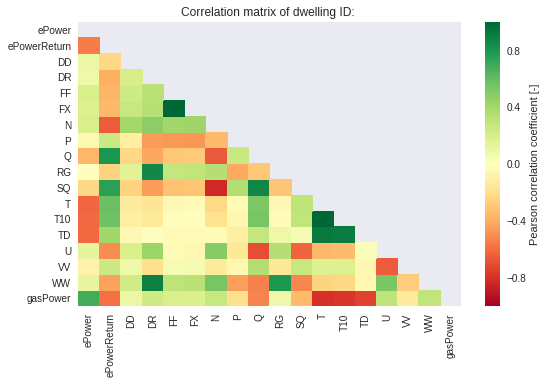

In [5]:
fig = create_corr_matrix(df, '', False)

# Select data to use

Saving heatmap
Len of data:  278


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

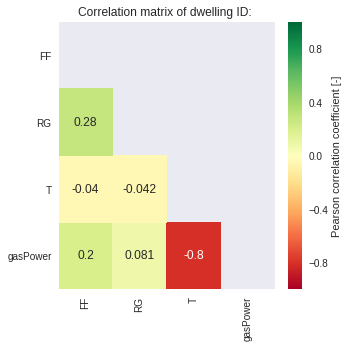

In [6]:
data = df
#data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'dwelling'], axis=1) # Not needed
data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)


#data = data[data['T'] < 0] #filter data based on condition
#data = data.reset_index()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude
data = data.dropna()

fig = create_corr_matrix(data, '', True, size=(5,5))

print('Len of data: ', len(data))

(array([736389., 736420., 736450., 736481., 736511., 736542., 736573.,
        736603., 736634., 736664.]), <a list of 10 Text xticklabel objects>)

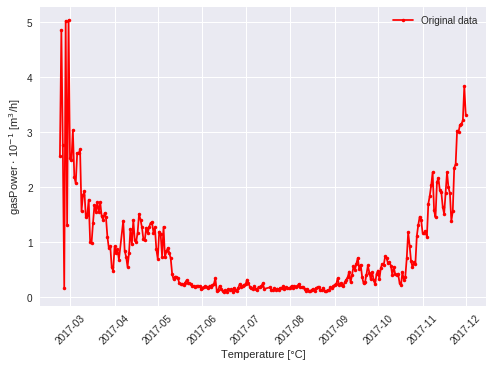

In [7]:
plt.plot(data.index, data['gasPower'], '.-', color='r', label='Original data')
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()
plt.xticks(rotation=45)

# Preprocessing

In [8]:
"""
Add a copy of gasPower column, so previous gasPower values are also in X_reshaped
"""
data['gasPower_copy'] = data['gasPower']
data.head()

,FF,RG,T,gasPower,gasPower_copy
datetime,,,,,
2017-02-22,8.236250,1.112500,9.236111,2.562459,2.562459
2017-02-23,11.608438,0.461319,8.590000,4.857127,4.857127
2017-02-24,5.032826,0.054306,4.746250,2.768300,2.768300
2017-02-25,6.502271,0.002083,5.606806,0.171661,0.171661
2017-02-26,7.540049,0.098611,8.688750,5.030009,5.030009


# Preprocessing, data to lstm format

In [9]:
look_back = 5
num_features = data.shape[1] - 1
output_dim = 1
test_size = 0.5

X_train, y_train, X_test, y_test = df_to_lstm_format(df=data, test_size=test_size, look_back=look_back, target_column='gasPower', scale_X=True)

In [10]:
def abs_percentage_error(y_true, y_pred):
    import keras.backend as K
    """
    Returns the absolute value of the difference between y_true and y_pred (in percentage).
    For examples on losses see:
    https://github.com/keras-team/keras/blob/master/keras/losses.py
    """
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

In [11]:
hidden_nodes = 35 # 35
epochs = 1000

# Create model
model = Sequential()

model.add(LSTM(hidden_nodes, input_shape=(look_back, num_features), kernel_initializer='TruncatedNormal'))
model.add(LeakyReLU())

#model.add(Dense(35, kernel_initializer='TruncatedNormal'))
#model.add(LeakyReLU())

#N = 256 #45  
#for i in range(4):
#    model.add(Dense(N-i*4, kernel_initializer='TruncatedNormal'))
#    model.add(LeakyReLU())
    #model.add(Dropout(0.5))


model.add(Dense(units=output_dim, kernel_initializer='TruncatedNormal'))
#model.add(Activation('linear'))

model = multi_gpu_model(model, gpus=num_gpu)

sgd = SGD(lr=0.005, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compile & fit
model.compile(optimizer='sgd', loss = ['mse'], metrics=['mse', abs_percentage_error])

KeyboardInterrupt: 

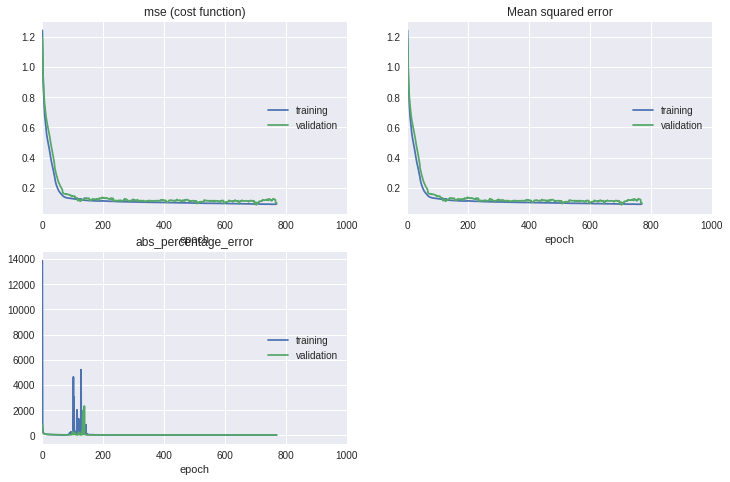

In [12]:
early_stopping_monitor = EarlyStopping(patience=1000)



model.fit(X_train, y_train, epochs=epochs, batch_size=int(len(X_train)/4), validation_data=(X_test, y_test),
         verbose=2, callbacks=[PlotLossesKeras(), early_stopping_monitor])

print(model.summary())

In [ ]:
# variables
df = data # should be a pandas dataframe
test_size = 0.5 # percentage to use for training
target_column = 'c' # target column name
scale_X = False
look_back = 5 # Amount of previous X values to look at when predicting the current y value


def df_to_lstm_format(df, test_size=0.5, look_back=5, target_column='target', scale_X=True):
    """
    Input is a Pandas DataFrame. 
    Output is a np array in the format of (samples, timesteps, features).
    Currently this function only accepts one target variable.

    Usage example:

    # variables
    df = data # should be a pandas dataframe
    test_size = 0.5 # percentage to use for training
    target_column = 'c' # target column name, all other columns are taken as features
    scale_X = False
    look_back = 5 # Amount of previous X values to look at when predicting the current y value
    """
    df = df.copy()

    # Make sure the target column is the last column in the dataframe
    df['target'] = df[target_column] # Make a copy of the target column
    df = df.drop(columns=[target_column]) # Drop the original target column
    
    target_location = df.shape[1] - 1 # column index number of target
    split_index = int(df.shape[0]*split) # the index at which to split df into train and test
    
    # ...train
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # ...test
    X_test = df.values[split_index:, :target_location] # original is split_index:-1
    y_test = df.values[split_index:, target_location] # original is split_index:-1

    # Scale the features
    if scale_X:
        scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
        
    # Reshape the arrays
    samples = len(X_train) # in this case 217 samples in the training set
    num_features = target_location # All columns before the target column are features

    samples_train = X_train.shape[0] - look_back
    X_train_reshaped = np.zeros((samples_train, look_back, n_features))
    y_train_reshaped = np.zeros((samples_train))

    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]


    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

In [13]:
y_preds = model.predict(X_test)
y_true = y_test.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*test_size)
x = data[split_index:]
len(y_true), len(x)

(134, 139)

In [14]:
datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # Correct for datetime difference, this is a dirty way of doing it

134/134 [==============================] - 0s 167us/step


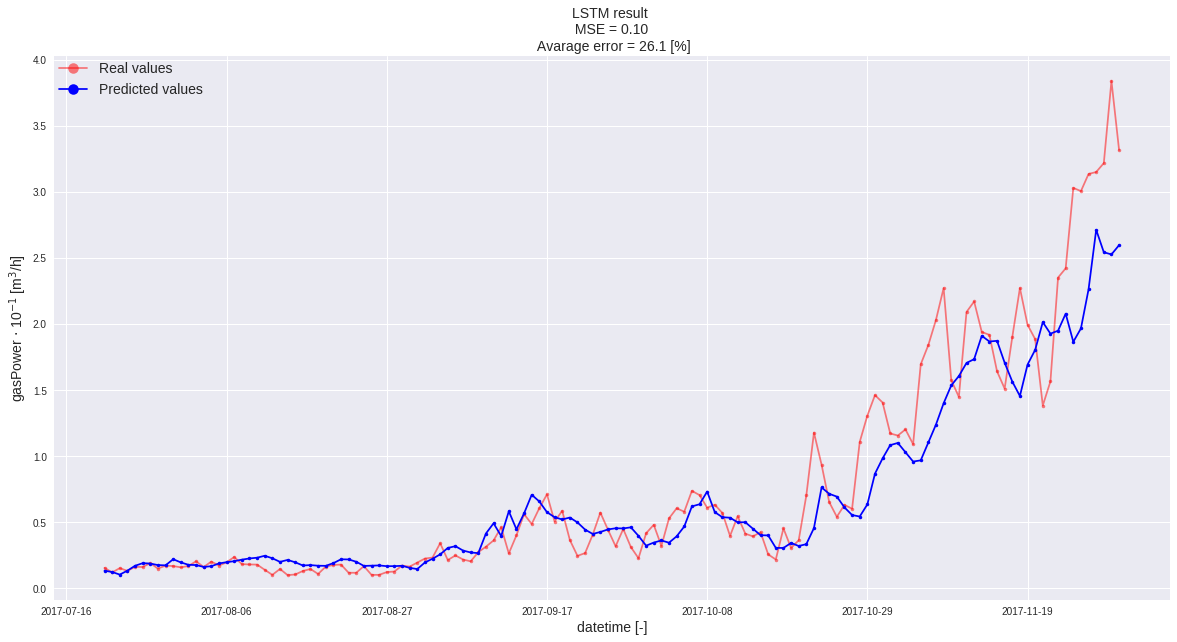

In [15]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='r', label='Real values', alpha=0.5)
plt.plot(x.index, y_preds, '.-', color='b', label='Predicted values')

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse = model.evaluate(X_test, y_test)[1]
perc = model.evaluate(X_test, y_test)[2]

plt.title('LSTM result \n MSE = %.2f \n Avarage error = %.1f [%%]' % (mse, perc), fontsize = 14)

plt.savefig('figures/LSTM result.png', dpi=1200)

In [ ]:
plt.savefig('figures/LSTM result.png', dpi=1200)
print('FINISHED')